In [1]:
import os
import random
import re
import pandas as pd
from openpyxl import load_workbook
from helpers import sql

In [2]:
    #   ==== NOTES ====
    #   for now, linkages to other themes have not been added. if there is a need, this could be updated
    #   other future options could include: abbreviation, bools, linked models, properties, etc
    #   what should have a theme?
    #     requests - YES
    #     documents - YES
    #     processes
    #     tor
    #     meetings
    #   should "Theme" have a more verbose name?
    #     it is not obvious what we're talking about, but SubjectMatter and Tag already exist
    #     we need clear language to disambiguate SubjectMatter tag (m2m) with Theme (FK)
    #     what are the differences relative to SubjectMatter?
    #       SubjectMatter
    #         Groundfish
    #         eDNA
    #         Herring
    #         Phytoplankton
    #         Marine Mammal
    #         Asian Carp
    #         Major Projects
    #         Impact Assessment
    #       Theme
    #         Marine mammals
    #         Fisheries
    #         Aquatic Invasive Species
    #         Species at Risk
    #         Marine Planning and Conservation
    #         Aquaculture
    #         FFHPP (include CSAS-IA team)

In [3]:
def extract_themes(folder_path):
    data = []

    for file_name in os.listdir(folder_path):
        if file_name.endswith(".xlsx") or file_name.endswith(".xlsm"):
            file_path = os.path.join(folder_path, file_name)
            workbook = load_workbook(file_path, data_only=False)

            for sheet_name in workbook.sheetnames:
                sheet = workbook[sheet_name]

                for row in sheet.iter_rows():
                    for cell in row:
                        if cell.hyperlink:
                            hyperlink = cell.hyperlink.target
                            match = re.search(r'/requests/(\d+)/', hyperlink)
                            data.append({
                                "theme": file_name.split(" ")[0], 
                                "sheetname": sheet_name, 
                                "id": match.group(1) if match else None
                            })

    return pd.DataFrame(data)

In [4]:
themes = extract_themes("./theme_data")
themes["id"] = themes["id"].astype("int64")

In [5]:
themes['theme'].value_counts()

theme
Fisheries          403
MarineMammals       48
FFHPP               44
SARP                42
Aquaculture         27
MPC                 21
AIS                 12
StrategicPolicy      4
EOS                  2
Name: count, dtype: int64

In [6]:
def prepend_table_name(df, table_name):
    return df.rename(columns=lambda col: f"{table_name}_{col}")

csas_request = sql("SELECT * FROM csas2_csasrequest;")
section = sql("SELECT * FROM shared_models_section;")
division = sql("SELECT * FROM shared_models_division;")
branch = sql("SELECT * FROM shared_models_branch;")
sector = sql("SELECT * FROM shared_models_sector;")

csas_request = prepend_table_name(csas_request, "csas_request").astype('object')
csas_request['office_name'] = csas_request['csas_request_office_id'].map({
    1: 'Gulf',
    2: 'Maritimes',
    3: 'Quebec',
    6: 'Newfoundland & Labrador',
    4: 'National',
    7: 'Ontario and Prairie',
    5: 'Pacific',
    8: 'Arctic',
}) 
section = prepend_table_name(section, "section").astype('object')
division = prepend_table_name(division, "division").astype('object')
branch = prepend_table_name(branch, "branch").astype('object')
sector = prepend_table_name(sector, "sector").astype('object')

combined_requests = (
    themes
    .merge(csas_request, left_on="id", right_on="csas_request_id", how="left", suffixes=("", "_request"))
    .merge(section, left_on="csas_request_section_id", right_on="section_id", how="left", suffixes=("", "_section"))
    .merge(division, left_on="section_division_id", right_on="division_id", how="left", suffixes=("", "_division"))
    .merge(branch, left_on="division_branch_id", right_on="branch_id", how="left", suffixes=("", "_branch"))
    .merge(sector, left_on="branch_sector_id", right_on="sector_id", how="left", suffixes=("", "_sector"))
)
combined_requests = combined_requests.astype('object')

In [7]:
len(combined_requests.columns)

98

In [8]:
MIN_NON_NULL = 100
MIN_UNIQUE_VALUES = 2
MAX_UNIQUE_VALUES = 100

useful_columns = combined_requests.describe(include='all').T
useful_columns = useful_columns[(useful_columns['count'] >= MIN_NON_NULL) & (useful_columns['unique'] >= MIN_UNIQUE_VALUES) & (useful_columns['unique'] <= MAX_UNIQUE_VALUES)]
display(useful_columns)

useful_columns = list(useful_columns.index)

C:\Users\CARRK\AppData\Local\Temp\1\ipykernel_23132\1989749301.py:5: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  useful_columns = combined_requests.describe(include='all').T
C:\Users\CARRK\AppData\Local\Temp\1\ipykernel_23132\1989749301.py:5: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  useful_columns = combined_requests.describe(include='all').T
C:\Users\CARRK\AppData\Local\Temp\1\ipykernel_23132\1989749301.py:5: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavio

,count,unique,top,freq
theme,603,9,Fisheries,403
sheetname,603,13,All_2024-25,191
csas_request_language,591,2,1,479
csas_request_is_multiregional,531.0,2.0,0.0,337.0
csas_request_has_funding,591.0,2.0,0.0,433.0
csas_request_funding_text,588,97,,396
csas_request_prioritization,539.0,3.0,1.0,342.0
csas_request_status,591,11,70,132
csas_request_section_id,591,53,129,95
csas_request_advice_fiscal_year_id,591,7,2026,253


In [9]:
useful_columns = [
    'theme',
    'csas_request_is_multiregional',
    # 'csas_request_office_id',
    # 'section_id',
    # 'division_id',
    # 'branch_id',
    # 'sector_id',
    'office_name',
    'section_name',
    'division_name',
    'branch_name',
    'sector_name',
]

In [10]:
df = combined_requests[useful_columns]

In [11]:
df['theme'].value_counts()

theme
Fisheries          403
MarineMammals       48
FFHPP               44
SARP                42
Aquaculture         27
MPC                 21
AIS                 12
StrategicPolicy      4
EOS                  2
Name: count, dtype: int64

In [12]:
for col in [x for x in useful_columns if x != 'theme']:
    display(df.groupby(col)['theme'].unique().reset_index())

,csas_request_is_multiregional,theme
0,0.0,"[AIS, Aquaculture, FFHPP, Fisheries, MarineMam..."
1,1.0,"[AIS, Aquaculture, EOS, FFHPP, Fisheries, Mari..."


,office_name,theme
0,Arctic,"[FFHPP, Fisheries, MarineMammals, MPC, SARP]"
1,Gulf,"[FFHPP, Fisheries]"
2,Maritimes,"[AIS, Aquaculture, FFHPP, Fisheries, MarineMam..."
3,National,"[AIS, Aquaculture, EOS, FFHPP, Fisheries, Mari..."
4,Newfoundland & Labrador,"[AIS, Aquaculture, FFHPP, Fisheries, SARP]"
5,Ontario and Prairie,"[AIS, FFHPP, SARP]"
6,Pacific,"[Aquaculture, FFHPP, Fisheries, MarineMammals,..."
7,Quebec,"[FFHPP, Fisheries, MarineMammals, MPC, SARP]"


,section_name,theme
0,Aboriginal Fisheries,[Fisheries]
1,Aquaculture,"[Aquaculture, Fisheries]"
2,Aquaculture Directorate,"[Aquaculture, Fisheries]"
3,Aquaculture Management,"[Aquaculture, Fisheries]"
4,Aquatic Invasive Species,"[AIS, Fisheries]"
5,Aquatic Invasive Species & Species at Risk,"[AIS, SARP]"
6,Aquatic Invasive Species National Core Program,[AIS]
7,Domestic Fisheries Policy,[StrategicPolicy]
8,Ecosystem Management,[FFHPP]
9,Ecosystems Management,[FFHPP]


,division_name,theme
0,Aquaculture Management,"[Aquaculture, Fisheries]"
1,Aquaculture Policy,"[Aquaculture, Fisheries]"
2,"Aquaculture, Biotechnology and Aquatic Animal ...",[Aquaculture]
3,Aquatic Ecosystems,"[AIS, FFHPP, MarineMammals, SARP]"
4,Aquatic Invasive Species,"[AIS, Fisheries]"
5,Aquatic Resources,"[Fisheries, MarineMammals]"
6,Biodiversity Program,"[MarineMammals, SARP]"
7,Domestic Fisheries Policy,[StrategicPolicy]
8,Ecosystem Management,[FFHPP]
9,Ecosystems Management,"[AIS, Aquaculture, FFHPP, MarineMammals, SARP]"


,branch_name,theme
0,Aquaculture Policy Directorate,"[Aquaculture, Fisheries]"
1,Aquatic Ecosystems,"[AIS, Aquaculture, FFHPP, MarineMammals, MPC, ..."
2,Biodiversity Management,"[AIS, Fisheries, SARP]"
3,Ecosystem Management Branch,"[FFHPP, MarineMammals, SARP]"
4,Ecosystem Sciences Directorate,"[AIS, EOS, MarineMammals, SARP]"
5,Ecosystems Management,"[FFHPP, MPC, SARP]"
6,Fisheries & Harbour Management,"[Fisheries, MarineMammals, MPC]"
7,Fisheries Management,"[Aquaculture, Fisheries, MarineMammals]"
8,"Fisheries Management, Resource and Aboriginal ...",[Fisheries]
9,Fisheries Policy,[StrategicPolicy]


,sector_name,theme
0,Aquatic Ecosystems,"[AIS, Aquaculture, FFHPP, Fisheries, MarineMam..."
1,Ecosystems & Oceans Science,"[AIS, Aquaculture, EOS, Fisheries, MarineMamma..."
2,Fisheries & Harbour Management,"[Aquaculture, Fisheries, MarineMammals, MPC]"
3,Strategic Policy,[StrategicPolicy]


In [13]:
# multiregional is useless
# division, branch, region are determined by section

useful_columns = ['theme', 'office_name', 'section_name', 'sector_name']
df = df[useful_columns]

In [14]:
def display_theme_counts(column):
    display(
        pd.DataFrame(df[column].value_counts())
        .merge(
            df.groupby(column)['theme'].unique().reset_index(),
            on=column,
            how='inner'
        ).sort_values(column)
     )

display_theme_counts('office_name')    
display_theme_counts('section_name')
display_theme_counts('sector_name')

,office_name,count,theme
4,Arctic,59,"[FFHPP, Fisheries, MarineMammals, MPC, SARP]"
7,Gulf,17,"[FFHPP, Fisheries]"
0,Maritimes,136,"[AIS, Aquaculture, FFHPP, Fisheries, MarineMam..."
3,National,86,"[AIS, Aquaculture, EOS, FFHPP, Fisheries, Mari..."
5,Newfoundland & Labrador,54,"[AIS, Aquaculture, FFHPP, Fisheries, SARP]"
6,Ontario and Prairie,23,"[AIS, FFHPP, SARP]"
2,Pacific,95,"[Aquaculture, FFHPP, Fisheries, MarineMammals,..."
1,Quebec,121,"[FFHPP, Fisheries, MarineMammals, MPC, SARP]"


,section_name,count,theme
2,Aboriginal Fisheries,89,[Fisheries]
11,Aquaculture,9,"[Aquaculture, Fisheries]"
8,Aquaculture Directorate,14,"[Aquaculture, Fisheries]"
13,Aquaculture Management,7,"[Aquaculture, Fisheries]"
10,Aquatic Invasive Species,10,"[AIS, Fisheries]"
21,Aquatic Invasive Species & Species at Risk,3,"[AIS, SARP]"
26,Aquatic Invasive Species National Core Program,2,[AIS]
22,Domestic Fisheries Policy,3,[StrategicPolicy]
30,Ecosystem Management,2,[FFHPP]
33,Ecosystems Management,1,[FFHPP]


,sector_name,count,theme
1,Aquatic Ecosystems,153,"[AIS, Aquaculture, FFHPP, Fisheries, MarineMam..."
2,Ecosystems & Oceans Science,33,"[AIS, Aquaculture, EOS, Fisheries, MarineMamma..."
0,Fisheries & Harbour Management,402,"[Aquaculture, Fisheries, MarineMammals, MPC]"
3,Strategic Policy,3,[StrategicPolicy]


# decision tree

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
X = pd.get_dummies(df.drop(columns=['theme']), drop_first=True).astype(bool)  # Force dtype to bool after get_dummies
y = df['theme']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

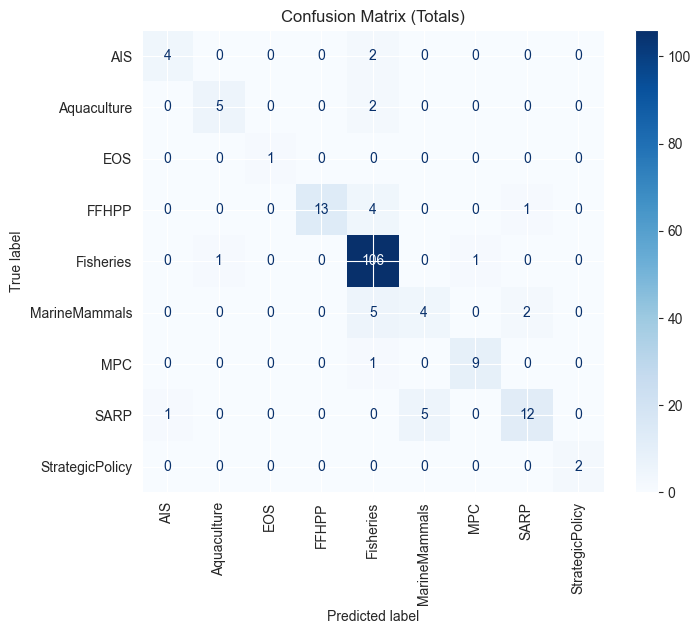

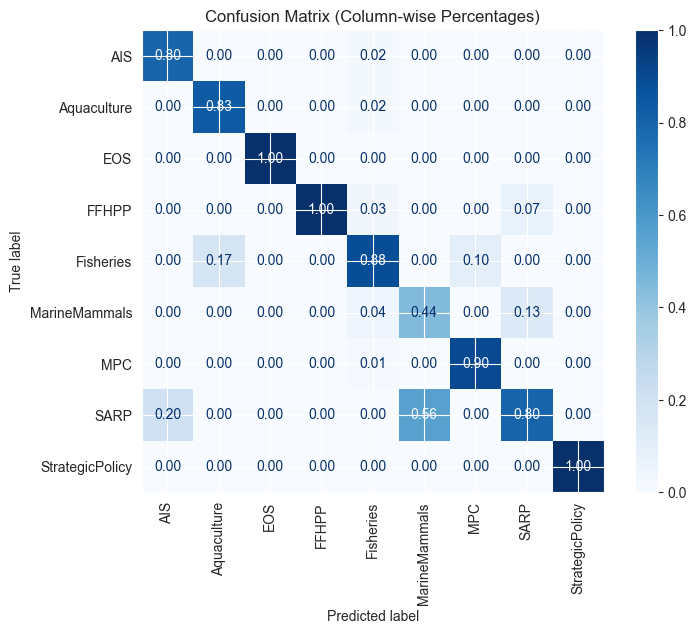

In [18]:
cm = confusion_matrix(y_test, y_pred, labels=y.unique())

cm_total = cm.astype('float')

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_total, display_labels=y.unique())
disp.plot(cmap='Blues', ax=plt.gca(), values_format=".0f")
plt.title("Confusion Matrix (Totals)")
ax = plt.gca()

ax.tick_params(axis='x', labelrotation=90, labelsize=10)
plt.title("Confusion Matrix (Totals)")
plt.show()

cm_percentage = cm.astype('float') / cm.sum(axis=0)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=y.unique())
disp.plot(cmap='Blues', ax=plt.gca(), values_format=".2f")
plt.title("Confusion Matrix (Column-wise Percentages)")
ax = plt.gca()

ax.tick_params(axis='x', labelrotation=90, labelsize=10)
plt.title("Confusion Matrix (Column-wise Percentages)")
plt.show()

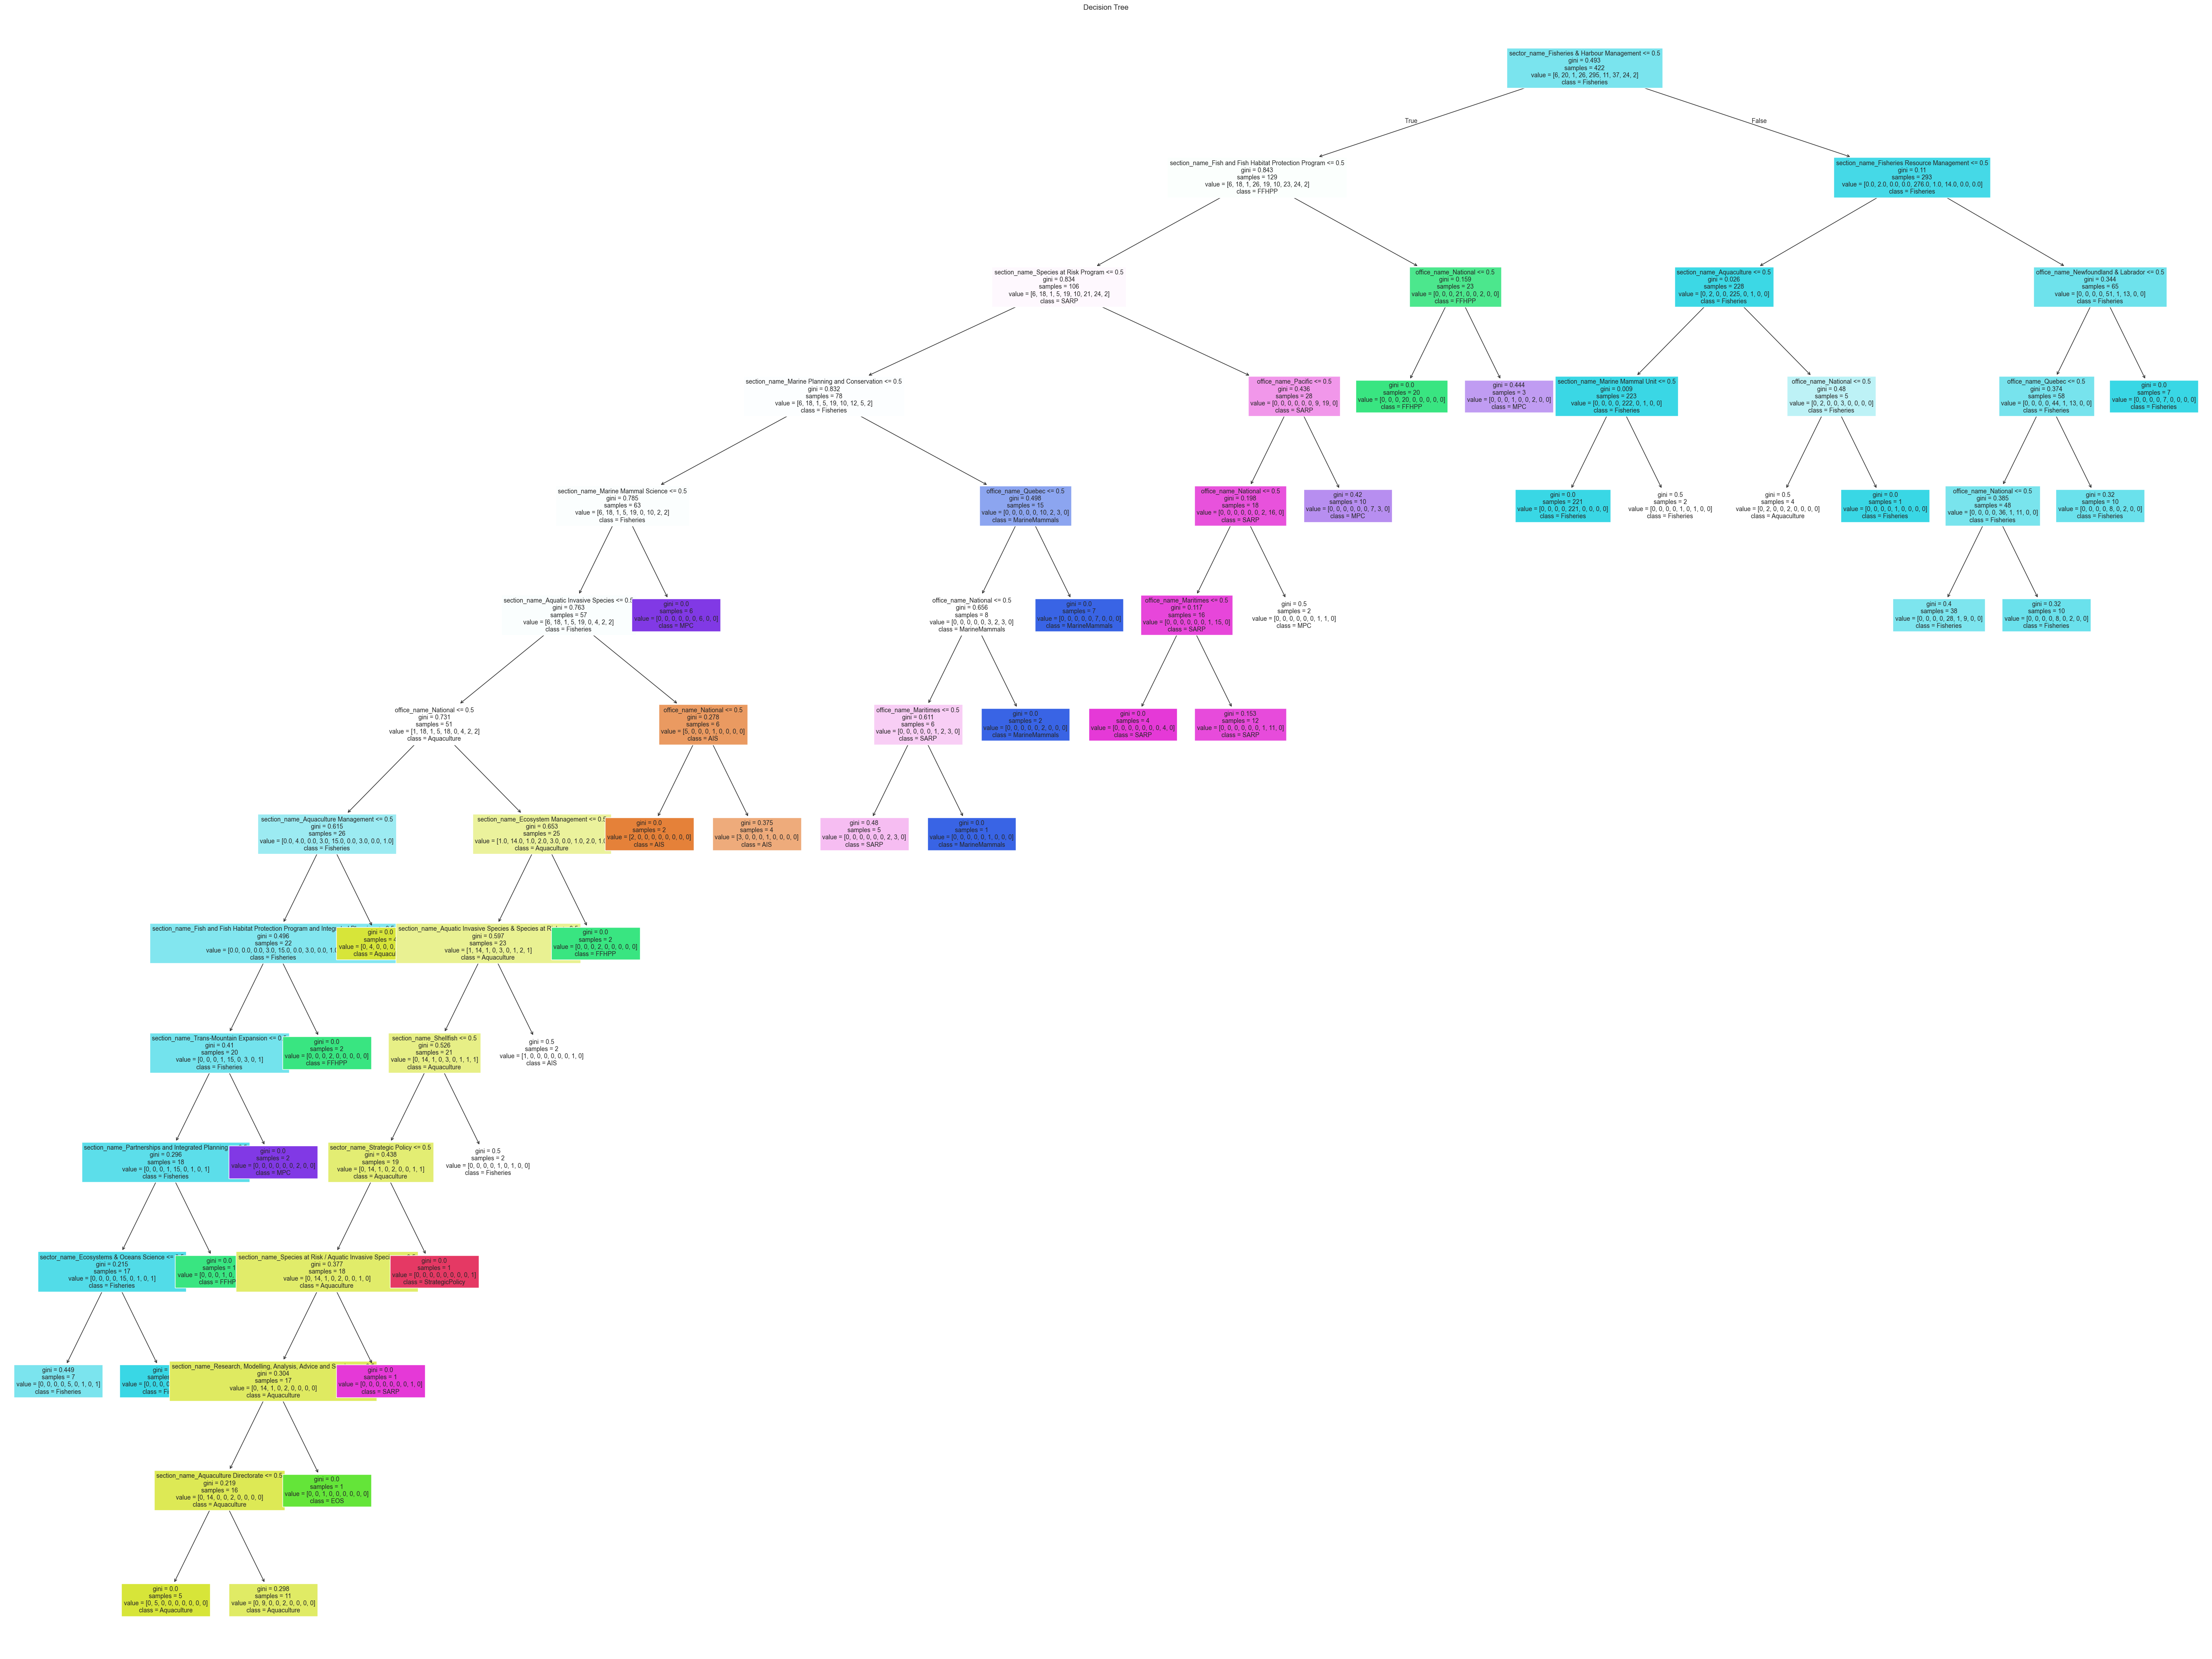

In [19]:
plt.figure(figsize=(64, 48))
plot_tree(clf, feature_names=X_train.columns, class_names=y.unique().astype(str), filled=True, fontsize=10)
plt.title("Decision Tree")
plt.show()

In [20]:
from sklearn.tree import export_text

print(export_text(clf, feature_names=list(X_train.columns)))

|--- sector_name_Fisheries & Harbour Management <= 0.50
|   |--- section_name_Fish and Fish Habitat Protection Program <= 0.50
|   |   |--- section_name_Species at Risk Program <= 0.50
|   |   |   |--- section_name_Marine Planning and Conservation <= 0.50
|   |   |   |   |--- section_name_Marine Mammal Science <= 0.50
|   |   |   |   |   |--- section_name_Aquatic Invasive Species <= 0.50
|   |   |   |   |   |   |--- office_name_National <= 0.50
|   |   |   |   |   |   |   |--- section_name_Aquaculture Management <= 0.50
|   |   |   |   |   |   |   |   |--- section_name_Fish and Fish Habitat Protection Program and Integrated Planning <= 0.50
|   |   |   |   |   |   |   |   |   |--- section_name_Trans-Mountain Expansion <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- section_name_Partnerships and Integrated Planning <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- section_name_Partnerships and Integrate

In [21]:
from sklearn.tree import _tree

def get_rules(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    def recurse(node):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            feature = feature_name[node]
            threshold = tree_.threshold[node]
            if threshold == 0.5:  # Boolean split
                left = recurse(tree_.children_left[node])
                right = recurse(tree_.children_right[node])
                return {feature: {"is False": left, "is True": right}}
            else:
                return f"{feature} <= {threshold}"
        else:
            return f"class {tree_.value[node].argmax()}"

    rules = recurse(0)
    return rules

rules = get_rules(clf, list(X_train.columns))
rules


{'sector_name_Fisheries & Harbour Management': {'is False': {'section_name_Fish and Fish Habitat Protection Program': {'is False': {'section_name_Species at Risk Program': {'is False': {'section_name_Marine Planning and Conservation': {'is False': {'section_name_Marine Mammal Science': {'is False': {'section_name_Aquatic Invasive Species': {'is False': {'office_name_National': {'is False': {'section_name_Aquaculture Management': {'is False': {'section_name_Fish and Fish Habitat Protection Program and Integrated Planning': {'is False': {'section_name_Trans-Mountain Expansion': {'is False': {'section_name_Partnerships and Integrated Planning': {'is False': {'sector_name_Ecosystems & Oceans Science': {'is False': 'class 4',
                        'is True': 'class 4'}},
                      'is True': 'class 3'}},
                    'is True': 'class 6'}},
                  'is True': 'class 3'}},
                'is True': 'class 1'}},
              'is True': {'section_name_Ecosystem

# wish.com decision tree

In [22]:
themes_by_section = df.groupby('section_name')['theme'].unique().apply(list).to_dict()
themes_by_sector = df.groupby('sector_name')['theme'].unique().apply(list).to_dict()
themes_by_office = df.groupby('office_name')['theme'].unique().apply(list).to_dict()

sections = list(themes_by_section.keys())
sectors = list(themes_by_sector.keys())
offices = list(themes_by_office.keys())

def predicted_theme(section_name, sector_name, office_name):
    return [x for x in themes_by_section[section_name] if x in themes_by_sector[sector_name] and x in themes_by_office[office_name]]

In [24]:
x, y, z = random.choice(sections), random.choice(sectors), random.choice(offices)
print(x, '\n', y, '\n', z, '\npredicted theme(s):')
predicted_theme(x, y, z)

Aquaculture Directorate 
 Fisheries & Harbour Management 
 Pacific 
predicted theme(s):


['Aquaculture', 'Fisheries']